In [25]:
%cd "C:\Users\braya\Documents\github\DeSign\BNN"

C:\Users\braya\Documents\github\DeSign\BNN


In [26]:

import math
import scipy.io as sio
import numpy as np
import tensorflow as tf


from tensorflow.keras.layers import Layer, CenterCrop

from binarynet.utils import binary_tanh_unit


class Threshold3D(Layer):

    def __init__(self,
                 filename='./thresholds/threshold_2x2_v1.mat',
                 **params):
        super(Threshold3D, self).__init__()

        self.filename = filename
        self.kernel = self.load_kernel(filename)

        if len(self.kernel.shape) == 2:
            self.kernel = self.kernel[..., None]
        
        self.kernel_size = self.kernel.shape
        self.kernel = tf.constant(self.kernel)[..., None]

    def build(self, input_shape):

        m, n, features = self.kernel_size
        M, N, channels = input_shape[1:]
        H, W = math.ceil(M/m), math.ceil(N/n)

        self.ones = self.add_weight('ones',
                                    shape=(1, H, W, 1),
                                    dtype=tf.float32,
                                    initializer='ones',
                                    trainable=False)

        self.crop = CenterCrop(M, N)

        self.oshape = tf.constant([1, H*m, W*n, features])
        self.replicates = int(channels / features)
        self.strides = (m, n)

    def load_kernel(self, filename):
        kernel = sio.loadmat(filename)['kernel']
        kernel = np.float32(kernel)
        return kernel
    
    def call(self, inputs):
 

        # spatial_thresh = self.conv2dtranpose(self.ones)
        spatial_thresh = tf.nn.conv2d_transpose(self.ones,
                                                self.kernel,
                                                self.oshape,
                                                strides=self.strides,
                                                padding='VALID')

        spatial_thresh = self.crop(spatial_thresh)
        spatial_thresh = tf.tile(spatial_thresh, [1, 1, 1, self.replicates])

        x = inputs - spatial_thresh
        return binary_tanh_unit(x)

    def get_config(self):

        config = super().get_config()
        config.update({
            "filename": self.filename,
        })
        return config

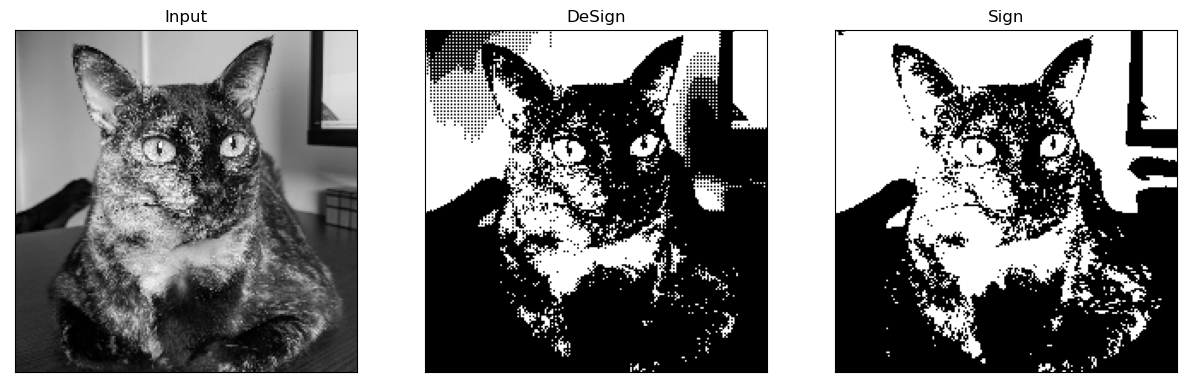

In [27]:
import cv2


size = 200
image = cv2.imread('ciri.jpg', cv2.IMREAD_GRAYSCALE)

# normalize
image = image / 255.0
image = image - np.mean(image)
image = image / np.std(image)

image = cv2.resize(image, (size, size))




DeSign = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(size, size, 1)),
    Threshold3D(),
])




inputs = tf.convert_to_tensor(image)[None, ..., None]
output_design = DeSign(inputs)
output_sign   = tf.sign(inputs)

import matplotlib.pyplot as plt


plt.figure(figsize=(15, 15))

plt.subplot(1, 3, 1)
plt.imshow(inputs[0, :, :, 0], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Input')

plt.subplot(1, 3, 2)
plt.imshow(output_design[0, :, :, 0], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('DeSign')

plt.subplot(1, 3, 3)
plt.imshow(output_sign[0, :, :, 0], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Sign')

plt.show()

